# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Problem studied
I want to Predict response of a customer to an offer. 

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

First, let's print a head of each dataframe

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


# Description of Dataframe

## Portfolio

I will check the content of portfolio

In [6]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


Overview of columns :

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [7]:
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [8]:
portfolio.channels

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [9]:
portfolio.shape

(10, 6)

There are three types of offers: BOGO (buy one get one), discount, and informational. Starbucks also uses four types of channels: web, email, mobile, and social media. The dataset contains 10 offer campaigns.

To make the data easier to use, I will split the 'channels' column into four columns, each populated with 0 or 1 to indicate the presence of each channel type.

In [10]:
# We keep only channels 
df_exploded = portfolio['channels'].explode()
dummies = pd.get_dummies(df_exploded)
channels_dummies = dummies.groupby(level=0).max()

# Concat with original df
portfolio = pd.concat([portfolio, channels_dummies], axis=1)

portfolio.drop("channels", axis=1, inplace = True)

portfolio


,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,True,True,True,False
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,True,True,True,True
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,True,True,False,True
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True,False,True
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,False,False,True
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,True,True,True,True
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,True,True,True,True
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,True,True,True,False
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,True,True,True,True
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,True,True,False,True


In [11]:
portfolio = portfolio.rename(columns={'id':'offer_id'})

## Profile

In [12]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


Overview of columns :

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [13]:
profile.shape

(17000, 5)

In [14]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [15]:
profile[profile.duplicated()]

,gender,age,id,became_member_on,income


The profile DataFrame contains data about age, gender, income, and a date. Using the describe function, we observe that the data seems realistic: age ranges between 18 and 118. No duplicate data is detected.
We will check for customer with age = 118 just to be sure that the data are realist. 


We have information for 17 000 customers.

Let's convert became_member_on to a more readable type

In [16]:
profile[profile.age == 118]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


We can conclude that 2175 customer over 17000 with an age of 118 isn't possible. Let's filtering these customer. 

In [17]:
profile = profile[profile.age <118]

In [18]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0


In [19]:
profile = profile.rename(columns={'id':'customer_id'})

## Transcript

In [20]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


Overview of columns :

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [21]:
transcript.shape

(306534, 4)

In [22]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

We have 306 534 informations about offer and customer. The type of event is 'offer received', 'offer viewed', 'transaction', 'offer completed' --> I'll create 4 columns for event to simplify treatment. 



In [23]:
# We keep only channels 
df_exploded = transcript['event'].explode()
dummies = pd.get_dummies(df_exploded)
channels_dummies = dummies.groupby(level=0).max()

# Concat with original df
transcript = pd.concat([transcript, channels_dummies], axis=1)

transcript.drop("event", axis=1, inplace = True)

transcript

,person,value,time,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,False,True,False,False
1,a03223e636434f42ac4c3df47e8bac43,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,False,True,False,False
2,e2127556f4f64592b11af22de27a7932,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,False,True,False,False
3,8ec6ce2a7e7949b1bf142def7d0e0586,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,False,True,False,False
4,68617ca6246f4fbc85e91a2a49552598,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,False,True,False,False
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,{'amount': 1.5899999999999999},714,False,False,False,True
306530,68213b08d99a4ae1b0dcb72aebd9aa35,{'amount': 9.53},714,False,False,False,True
306531,a00058cf10334a308c68e7631c529907,{'amount': 3.61},714,False,False,False,True
306532,76ddbd6576844afe811f1a3c0fbb5bec,{'amount': 3.5300000000000002},714,False,False,False,True


We can see that value will be complicated to treat. We will replace this column and parse the content to create new columns. 

In [24]:
expanded_df = pd.json_normalize(transcript['value'])
transcript = pd.concat([transcript.drop(columns=['value']), expanded_df], axis=1)

In [25]:
#let's concat data from offer id and offer_id 

transcript["offer_id"] = transcript.apply(lambda row: row["offer id"] if pd.isna(row["offer_id"]) else row["offer_id"], axis=1)
transcript.drop("offer id", axis = 1, inplace = True)

In [26]:
transcript

,person,time,offer completed,offer received,offer viewed,transaction,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,0,False,True,False,False,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,False,True,False,False,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,False,True,False,False,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,False,True,False,False,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,False,True,False,False,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,False,False,False,True,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,False,False,False,True,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,714,False,False,False,True,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,False,False,False,True,3.53,NaN,NaN


In [27]:
transcript = transcript.rename(columns={'person':'customer_id'})

## Final Dataframe

Let's merge the 3 dataframe

In [28]:
transcript_profile = pd.merge(transcript, profile, on ="customer_id")
transcript_profile

,customer_id,time,offer completed,offer received,offer viewed,transaction,amount,offer_id,reward,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,0,False,True,False,False,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0
1,e2127556f4f64592b11af22de27a7932,0,False,True,False,False,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,M,68,2018-04-26,70000.0
2,389bc3fa690240e798340f5a15918d5c,0,False,True,False,False,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,M,65,2018-02-09,53000.0
3,2eeac8d8feae4a8cad5a6af0499a211d,0,False,True,False,False,NaN,3f207df678b143eea3cee63160fa8bed,NaN,M,58,2017-11-11,51000.0
4,aa4862eba776480b8bb9c68455b8c2e1,0,False,True,False,False,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,F,61,2017-09-11,57000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,24f56b5e1849462093931b164eb803b5,714,True,False,False,False,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,F,48,2017-12-28,80000.0
272758,b3a1272bc9904337b331bf348c3e8c17,714,False,False,False,True,1.59,NaN,NaN,M,66,2018-01-01,47000.0
272759,68213b08d99a4ae1b0dcb72aebd9aa35,714,False,False,False,True,9.53,NaN,NaN,M,52,2018-04-08,62000.0
272760,a00058cf10334a308c68e7631c529907,714,False,False,False,True,3.61,NaN,NaN,F,63,2013-09-22,52000.0


In [29]:
df = pd.merge(transcript_profile, portfolio, on='offer_id', how='left')
df

,customer_id,time,offer completed,offer received,offer viewed,transaction,amount,offer_id,reward_x,gender,...,became_member_on,income,reward_y,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,False,True,False,False,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,True,True,False,True
1,e2127556f4f64592b11af22de27a7932,0,False,True,False,False,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,M,...,2018-04-26,70000.0,2.0,10.0,7.0,discount,True,True,False,True
2,389bc3fa690240e798340f5a15918d5c,0,False,True,False,False,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,M,...,2018-02-09,53000.0,5.0,5.0,5.0,bogo,True,True,True,True
3,2eeac8d8feae4a8cad5a6af0499a211d,0,False,True,False,False,NaN,3f207df678b143eea3cee63160fa8bed,NaN,M,...,2017-11-11,51000.0,0.0,0.0,4.0,informational,True,True,False,True
4,aa4862eba776480b8bb9c68455b8c2e1,0,False,True,False,False,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,F,...,2017-09-11,57000.0,5.0,20.0,10.0,discount,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,24f56b5e1849462093931b164eb803b5,714,True,False,False,False,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,F,...,2017-12-28,80000.0,2.0,10.0,10.0,discount,True,True,True,True
272758,b3a1272bc9904337b331bf348c3e8c17,714,False,False,False,True,1.59,NaN,NaN,M,...,2018-01-01,47000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272759,68213b08d99a4ae1b0dcb72aebd9aa35,714,False,False,False,True,9.53,NaN,NaN,M,...,2018-04-08,62000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272760,a00058cf10334a308c68e7631c529907,714,False,False,False,True,3.61,NaN,NaN,F,...,2013-09-22,52000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df.columns

Index(['customer_id', 'time', 'offer completed', 'offer received',
       'offer viewed', 'transaction', 'amount', 'offer_id', 'reward_x',
       'gender', 'age', 'became_member_on', 'income', 'reward_y', 'difficulty',
       'duration', 'offer_type', 'email', 'mobile', 'social', 'web'],
      dtype='object')

# Data Exploration / Visualization :

In [31]:
df.describe()

,time,amount,reward_x,age,became_member_on,income,reward_y,difficulty,duration
count,272762.000000,123957.000000,32444.000000,272762.000000,272762,272762.000000,148805.000000,148805.000000,148805.000000
mean,366.707694,13.996325,4.948249,53.840696,2016-12-21 16:59:35.477522176,64337.000755,4.442445,7.890561,6.625207
min,0.000000,0.050000,2.000000,18.000000,2013-07-29 00:00:00,30000.000000,0.000000,0.000000,3.000000
25%,186.000000,3.660000,2.000000,41.000000,2016-03-16 00:00:00,48000.000000,2.000000,5.000000,5.000000
50%,408.000000,10.800000,5.000000,55.000000,2017-04-11 00:00:00,62000.000000,5.000000,10.000000,7.000000
75%,528.000000,19.130000,5.000000,66.000000,2017-11-26 00:00:00,78000.000000,5.000000,10.000000,7.000000
max,714.000000,1062.280000,10.000000,101.000000,2018-07-26 00:00:00,120000.000000,10.000000,20.000000,10.000000
std,200.359087,31.749420,2.905376,17.551337,NaN,21243.762941,3.372362,5.041335,2.133035


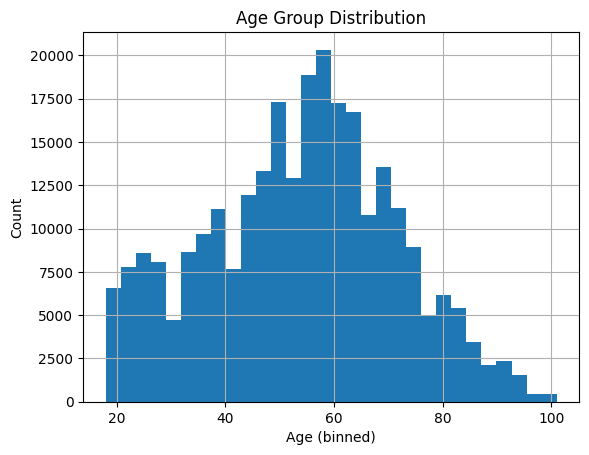

In [32]:
df.age.hist(bins = 30)
plt.xlabel('Age (binned)')
plt.ylabel('Count')
plt.title('Age Group Distribution');

The customer of Starbuck seems to be between 40 and 60. 

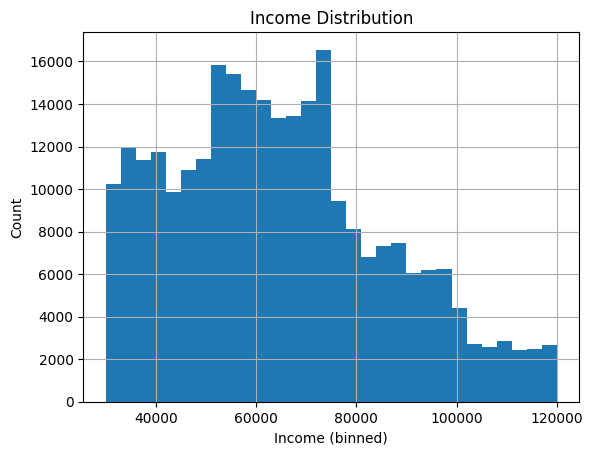

In [33]:
df.income.hist(bins = 30)
plt.xlabel('Income (binned)')
plt.ylabel('Count')
plt.title('Income Distribution');

We observe that income of customer is between 50 000 and 80 000.

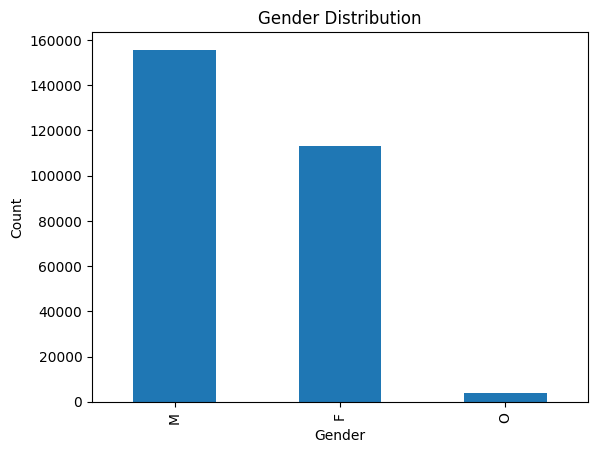

In [34]:
df.gender.value_counts().plot(kind="bar")
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution');

We observe that there is less female than male in the customer. 

In [35]:
df_bogo = df[df.offer_type =="bogo"]

nb_bogo = df_bogo.shape[0]
nb_bogo_completed = df_bogo["offer completed"].sum()
nb_bogo_received = df_bogo["offer received"].sum()
nb_bogo_viewed = df_bogo["offer viewed"].sum()

print(f'Number of BOGO offer received {nb_bogo_received}')

print(f'Number of BOGO offer viewed {nb_bogo_viewed} ({nb_bogo_viewed/nb_bogo_received*100:.2f}% of received)')
print(f'Number of BOGO offer completed {nb_bogo_completed} ({nb_bogo_completed/nb_bogo_received*100:.2f}% of received -  {nb_bogo_completed/nb_bogo_viewed*100:.2f}% of viewed)')

Number of BOGO offer received 26537
Number of BOGO offer viewed 22039 (83.05% of received)
Number of BOGO offer completed 15258 (57.50% of received -  69.23% of viewed)


In [36]:
df_discount = df[df.offer_type =="discount"]

nb_discount = df_discount.shape[0]
nb_discount_completed = df_discount["offer completed"].sum()
nb_discount_received = df_discount["offer received"].sum()
nb_discount_viewed = df_discount["offer viewed"].sum()

print(f'Number of discount offer received {nb_discount_received}')

print(f'Number of discount offer viewed {nb_discount_viewed} ({nb_discount_viewed/nb_discount_received*100:.2f}% of received)')
print(f'Number of discount offer completed {nb_discount_completed} ({nb_discount_completed/nb_discount_received*100:.2f}% of received -  {nb_discount_completed/nb_discount_viewed*100:.2f}% of viewed)')

Number of discount offer received 26664
Number of discount offer viewed 18461 (69.24% of received)
Number of discount offer completed 17186 (64.45% of received -  93.09% of viewed)


In [37]:
df_informational = df[df.offer_type =="informational"]

nb_informational = df_informational.shape[0]
nb_informational_received = df_informational["offer received"].sum()
nb_informational_viewed = df_informational["offer viewed"].sum()

print(f'Number of informational offer received {nb_informational_received}')

print(f'Number of informational offer viewed {nb_informational_viewed} ({nb_informational_viewed/nb_informational_received*100:.2f}% of received)')

Number of informational offer received 13300
Number of informational offer viewed 9360 (70.38% of received)


We can conclude :

* Discount offer is more completed than BOGO
* BOGO offer is more viewed than discount
* Informational offer is viewed as much as discount

In [38]:

numeric_columns = df.select_dtypes(include=['number', 'bool']).columns

df_stats_by_offer = df.groupby("offer_id")[numeric_columns].sum()

df_stats_by_offer["percent_completed"] = df_stats_by_offer["offer completed"] / df_stats_by_offer["offer received"] *100
df_stats_by_offer["percent_viewed"] = df_stats_by_offer["offer viewed"] / df_stats_by_offer["offer received"] * 100
df_stats_by_offer

,time,offer completed,offer received,offer viewed,transaction,amount,reward_x,age,income,reward_y,difficulty,duration,percent_completed,percent_viewed
offer_id,,,,,,,,,,,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,4495848,3386,6726,2215,0,0.0,16930.0,683274,8.360120e+08,61635.0,246540.0,123270.0,50.341957,32.931906
2298d6c36e964ae4a3e7e9706d1fb8c2,6445404,4886,6655,6379,0,0.0,14658.0,975694,1.177609e+09,53760.0,125440.0,125440.0,73.418482,95.852742
2906b810c7d4411798c6938adc9daaa5,5033130,3911,6631,3460,0,0.0,7822.0,771937,9.437050e+08,28004.0,140020.0,98014.0,58.980546,52.179158
3f207df678b143eea3cee63160fa8bed,3471786,0,6657,3487,0,0.0,0.0,558510,6.725460e+08,0.0,0.0,40576.0,0.000000,52.380952
4d5c57ea9a6940dd891ad53e9dbe8da0,5715066,3310,6593,6329,0,0.0,33100.0,890204,1.086702e+09,162320.0,162320.0,81160.0,50.204763,95.995753
5a8bc65990b245e5a138643cd4eb9837,4295856,0,6643,5873,0,0.0,0.0,678630,8.105600e+08,0.0,0.0,37548.0,0.000000,88.408851
9b98b8c7a33c4b65b9aebfe6a799e6d9,5206986,4188,6685,3499,0,0.0,20940.0,789873,9.576640e+08,71860.0,71860.0,100604.0,62.647719,52.341062
ae264e3637204a6fb9bb56bc8210ddfd,5726526,3657,6683,5901,0,0.0,36570.0,885436,1.079177e+09,162410.0,162410.0,113687.0,54.720934,88.298668
f19421c1d4aa40978ebb69ca19b0e20d,5948640,4103,6576,6310,0,0.0,20515.0,930435,1.126042e+09,84945.0,84945.0,84945.0,62.393552,95.954988


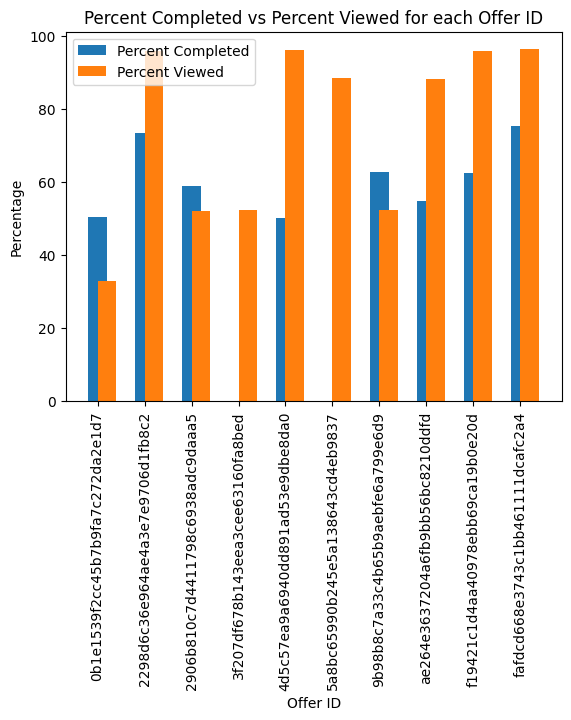

In [39]:
x = df_stats_by_offer.index
fig, ax = plt.subplots()

# Barres pour 'percent_completed'
ax.bar(x, df_stats_by_offer['percent_completed'], width=0.4, label='Percent Completed', align='center')

# Barres pour 'percent_viewed', légèrement décalées
ax.bar(x, df_stats_by_offer['percent_viewed'], width=0.4, label='Percent Viewed', align='edge')


ax.set_xlabel('Offer ID')
ax.set_ylabel('Percentage')
ax.set_title('Percent Completed vs Percent Viewed for each Offer ID')


ax.legend()
plt.xticks(rotation=90)

plt.show()

In my opinion, it's strange that for some offer IDs, there are more completions than views.

We can also observe a disparity in the percentage of completions versus views for each offer.

# Behaviour prediction

In [40]:
#Fisrt I'll group the dataframe in order to have in one line the complete information for the couple (offer, customer)
#This step could also be done in the first part of this notebook. But In my mind, this operation "groupby" is linked with data science and not data exploration. If we put this code at the end of data preparation, the data analysis part will be the same. 
df_answer_by_offer_customer = df.groupby(["offer_id","customer_id"]).agg({
    "offer completed": "any",
    "offer received": "any",
    "offer viewed": "any",
    "transaction" : "any",
    
    "amount" : "max",
    "reward_x" : "max",
    "age" : "max",
    "became_member_on" : "first",
    "gender" : "first",
    "income" : "max",
    "reward_y" : "max",
    "difficulty" : "max",
    "duration" : "max",
    "offer_type" : "first",
    "email" : "any",
    "mobile" : "any",
    "social" : "any",
    "web" : "any"
})
df_answer_by_offer_customer = df_answer_by_offer_customer.reset_index()

In [41]:
#Same comment as before, I'll replace Gender by a one-hot encoding just for data science. Not usefull for data exploration. 


#Use of one-hot encoding for Gender & Offer_type 
dummies = pd.get_dummies(df_answer_by_offer_customer[["gender", "offer_type"]])
channels_dummies = dummies.groupby(level=0).max()

# Concat with original df
df_answer_by_offer_customer = pd.concat([df_answer_by_offer_customer, channels_dummies], axis=1)


In [42]:
df_answer_by_offer_customer.head()

,offer_id,customer_id,offer completed,offer received,offer viewed,transaction,amount,reward_x,age,became_member_on,...,email,mobile,social,web,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0011e0d4e6b944f998e987f904e8c1e5,True,True,True,False,NaN,5.0,40,2018-01-09,...,True,False,False,True,False,False,True,False,True,False
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,003d66b6608740288d6cc97a6903f4f0,True,True,False,False,NaN,5.0,26,2017-06-21,...,True,False,False,True,True,False,False,False,True,False
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,00426fe3ffde4c6b9cb9ad6d077a13ea,False,True,False,False,NaN,NaN,19,2016-08-09,...,True,False,False,True,True,False,False,False,True,False
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,0056df74b63b4298809f0b375a304cf4,True,True,False,False,NaN,5.0,54,2016-08-21,...,True,False,False,True,False,True,False,False,True,False
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,00715b6e55c3431cb56ff7307eb19675,True,True,True,False,NaN,5.0,58,2017-12-07,...,True,False,False,True,True,False,False,False,True,False


In [43]:
X = df_answer_by_offer_customer[[ 'offer received',
       'offer viewed', 'transaction', 'age','difficulty', 'duration',
       'income', 'email', 'mobile', 'social', 'web', 'gender_F', 'gender_M', 'gender_O', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational']]
Y = df_answer_by_offer_customer['offer completed']

In [44]:
df_answer_by_offer_customer.head()

,offer_id,customer_id,offer completed,offer received,offer viewed,transaction,amount,reward_x,age,became_member_on,...,email,mobile,social,web,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0011e0d4e6b944f998e987f904e8c1e5,True,True,True,False,NaN,5.0,40,2018-01-09,...,True,False,False,True,False,False,True,False,True,False
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,003d66b6608740288d6cc97a6903f4f0,True,True,False,False,NaN,5.0,26,2017-06-21,...,True,False,False,True,True,False,False,False,True,False
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,00426fe3ffde4c6b9cb9ad6d077a13ea,False,True,False,False,NaN,NaN,19,2016-08-09,...,True,False,False,True,True,False,False,False,True,False
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,0056df74b63b4298809f0b375a304cf4,True,True,False,False,NaN,5.0,54,2016-08-21,...,True,False,False,True,False,True,False,False,True,False
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,00715b6e55c3431cb56ff7307eb19675,True,True,True,False,NaN,5.0,58,2017-12-07,...,True,False,False,True,True,False,False,False,True,False


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Model Training 

We will test 2 types of model. Gradient Boosting & Logistic Regression. 

In order to compare them, I'll use : Accuracy, Precision, Recall and F1-Score. 

# Accuracy 
Accuracy is the simplest and most intuitive metric, representing the proportion of correct predictions among all predictions. It is calculated as:

Accuracy = Number of correct predictions / Total number of predictions

# Precision
Precision measures the proportion of positive predictions that are actually correct. It is defined as: Precision = True_Positive / (True_Positive + False_Positive)

# Recall
Recall measures the proportion of actual positive cases that are correctly identified. It is defined as: Recall = True_Positive / (True_Positive + False_Negative)

# F1-Score

The F1-Score is the harmonic mean of precision and recall, providing a metric that balances both false positives and false negatives. It is defined as: F1-Score = (Precision * Recall) / (Precision + Recall) * 2 

The F1-Score will be used to compare the two models. It combines precision and recall, making it a good metric for providing a complete overview of a model's performance

## Test of GradientBoostingClassifier

In [46]:
pipelineGB = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Imputer les valeurs manquantes avec la moyenne
    ('scaler', StandardScaler()),                 # Étape de standardisation
    ('model', GradientBoostingClassifier())       # Modèle de Gradient Boosting
])

In [47]:
pipelineGB.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model', GradientBoostingClassifier())])

In [48]:
y_pred = pipelineGB.predict(X_test)

In [49]:
# Évaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7671877829419931

Classification Report:
               precision    recall  f1-score   support

       False       0.82      0.67      0.74      8146
        True       0.73      0.86      0.79      8421

    accuracy                           0.77     16567
   macro avg       0.78      0.77      0.76     16567
weighted avg       0.77      0.77      0.77     16567



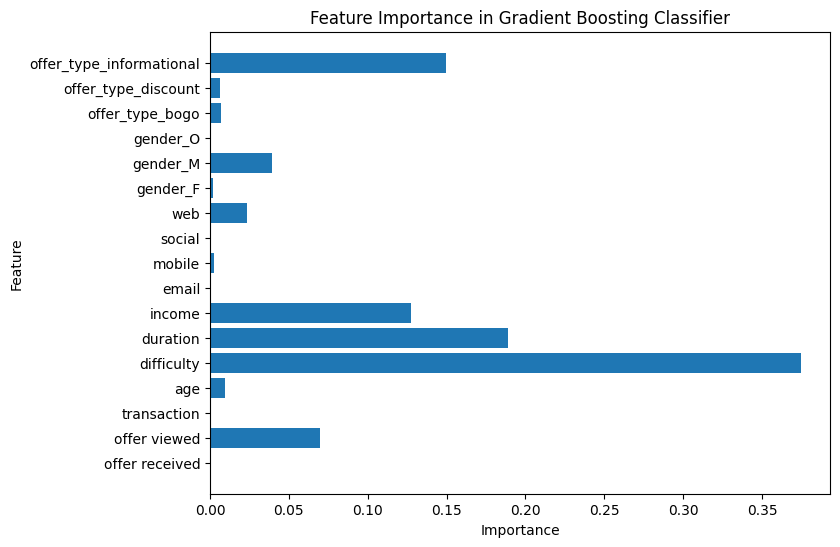

In [50]:
#Feature importance visualisation
feature_importances = pipelineGB["model"].feature_importances_
features = X.columns

plt.figure(figsize=(8, 6))
plt.barh(features, feature_importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Gradient Boosting Classifier")
plt.show()

With this image we can conclude that the feature the most important is the offer type, the difficulty of the compaign, followed by the duration, and customer's income. 

Please see the first tree of this model just for fun ! 

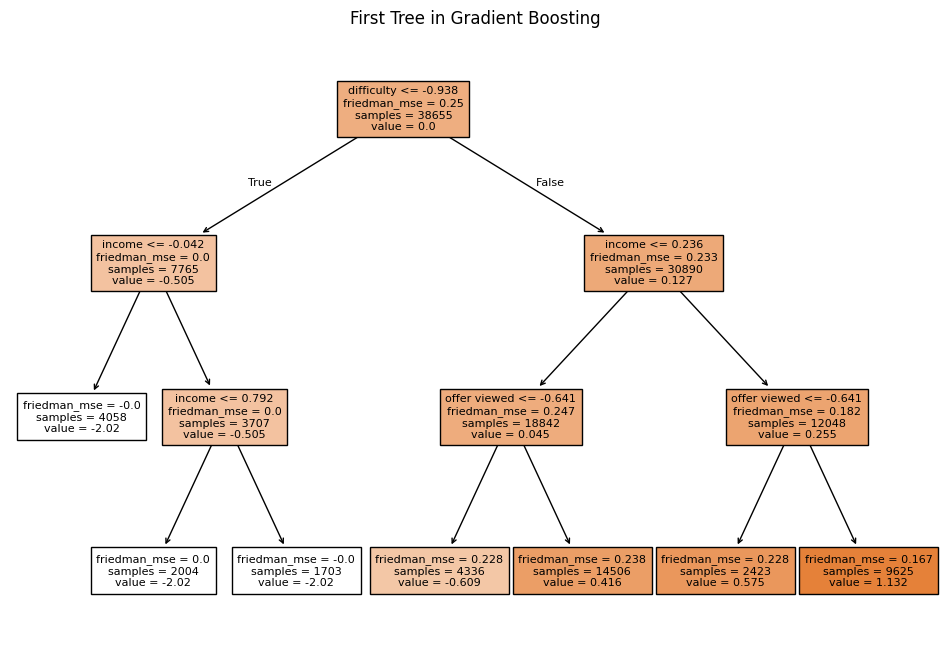

In [51]:
from sklearn.tree import plot_tree

# Visualiser le premier arbre
plt.figure(figsize=(12, 8))
plot_tree(pipelineGB["model"].estimators_[0, 0], filled=True, feature_names=X.columns, fontsize=8)
plt.title("First Tree in Gradient Boosting")
plt.show()


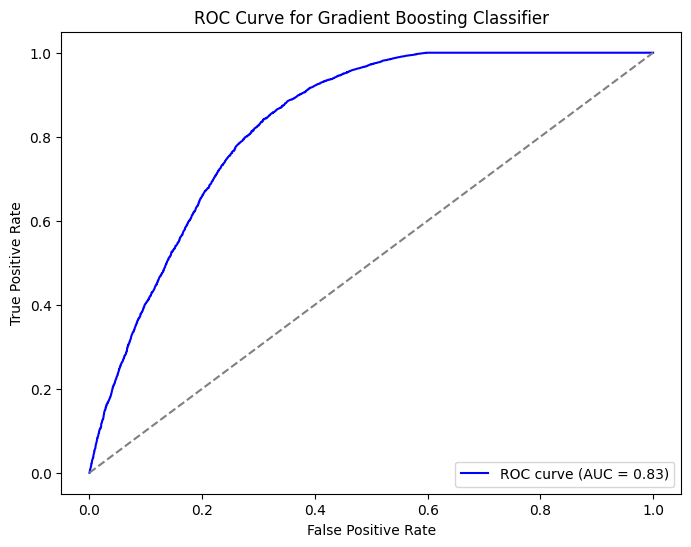

In [52]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
pipelineGB["model"].fit(X_train, y_train)

# Prédire les probabilités pour calculer la courbe ROC
y_pred_proba = pipelineGB["model"].predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Gradient Boosting Classifier")
plt.legend(loc="lower right")
plt.show()


The AUC of 0.83 is a good value for our subject. Every positive predicted by the model is a real one at 83%. 

In [53]:
# Évaluation

pipelineGB.fit(X_train, y_train)
y_pred = pipelineGB.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7671877829419931

Classification Report:
               precision    recall  f1-score   support

       False       0.82      0.67      0.74      8146
        True       0.73      0.86      0.79      8421

    accuracy                           0.77     16567
   macro avg       0.78      0.77      0.76     16567
weighted avg       0.77      0.77      0.77     16567



The F1-Score of 0.77 indicates a good balance between precision and recall, reflecting a model that performs reasonably well in both minimizing false positives and capturing true positives.

## Test of Logistic Regression

In [54]:
pipelineLR = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Imputer les valeurs manquantes avec la moyenne
    ('scaler', StandardScaler()),                 # Étape de standardisation
    ('model', LogisticRegression())       # Modèle de LogisticRegression
])

In [55]:

pipelineLR.fit(X_train, y_train)
y_pred = pipelineLR.predict(X_test)

In [56]:
import numpy as np

# Afficher les coefficients et leurs interprétations
feature_names = X.columns  # Nom des colonnes de X
coefficients = pipelineLR["model"].coef_[0]  # Coefficients de la régression logistique
odds_ratios = np.exp(coefficients)

for feature, odds_ratio in zip(feature_names, odds_ratios):
    print(f"{feature}: odds ratio = {odds_ratio:.4f}")


offer received: odds ratio = 1.0000
offer viewed: odds ratio = 1.5552
transaction: odds ratio = 1.0000
age: odds ratio = 1.0573
difficulty: odds ratio = 0.4973
duration: odds ratio = 1.4436
income: odds ratio = 1.6229
email: odds ratio = 1.0000
mobile: odds ratio = 0.8648
social: odds ratio = 0.9177
web: odds ratio = 1.0140
gender_F: odds ratio = 1.1500
gender_M: odds ratio = 0.8612
gender_O: odds ratio = 1.0442
offer_type_bogo: odds ratio = 3.0959
offer_type_discount: odds ratio = 3.8375
offer_type_informational: odds ratio = 0.0485


In [57]:
# Évaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7634454035130078

Classification Report:
               precision    recall  f1-score   support

       False       0.82      0.67      0.74      8146
        True       0.73      0.85      0.79      8421

    accuracy                           0.76     16567
   macro avg       0.77      0.76      0.76     16567
weighted avg       0.77      0.76      0.76     16567



This F1-Score is the same as the first model. 

# Business Impact
By implementing this type of model, Starbucks can:

Personalize Offers: Tailor offers to customers who are more likely to respond positively.

Optimize Marketing Budget: Focus resources on campaigns with the highest potential ROI.

Enhance Customer Retention: Improve the customer experience with relevant and timely offers.

# Conclusion
This project demonstrates how data science can provide valuable insights into customer behavior, enabling businesses like Starbucks to make informed decisions.

Predicting customer responses to offers is a powerful tool for improving marketing strategies and fostering stronger relationships with customers.

However, please note that this data is fictional, and building an actual predictive model for customer behavior is much more complex in reality.